In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM,SimpleRNN,Dropout
from keras.callbacks import History


import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM


import time #helper libraries
from sklearn.preprocessing import MinMaxScaler

from numpy import newaxis

import time

# For time stamps
from datetime import datetime
import yfinance as yf

In [2]:
stock_data = yf.download('TCS',start='2012-01-01',end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


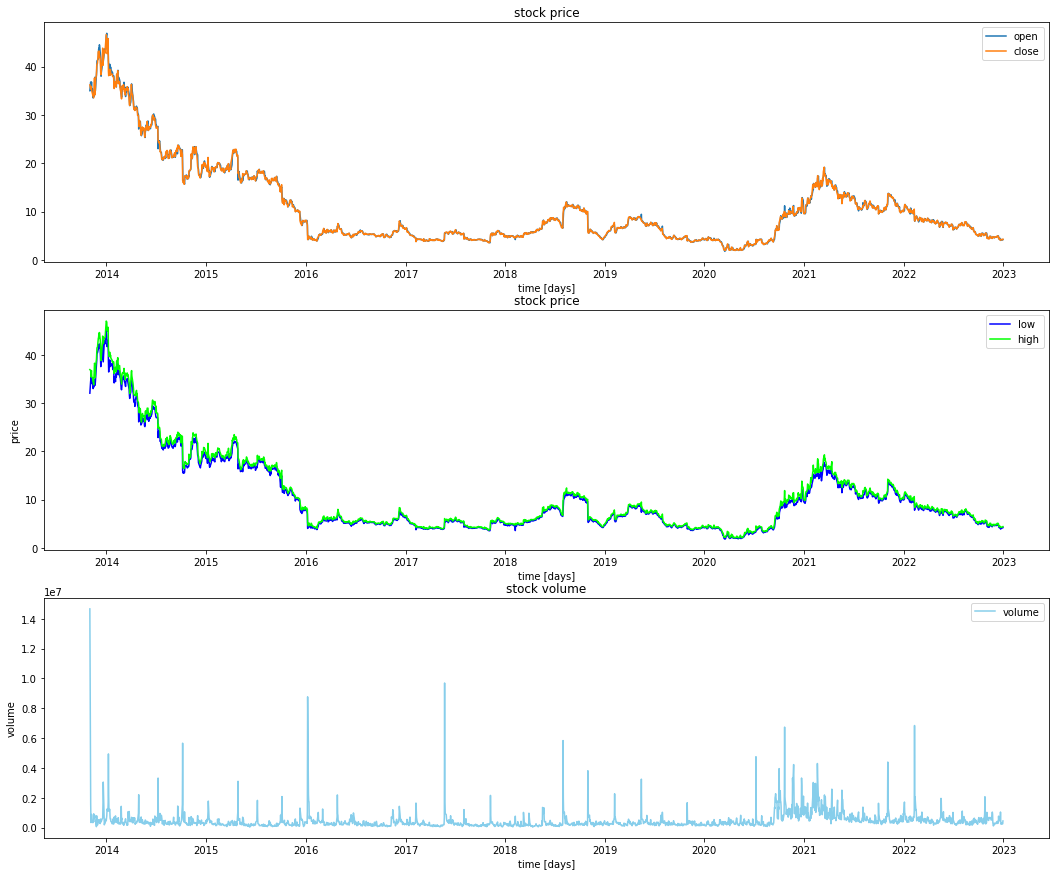

In [3]:
plt.figure(figsize=(18,15));
plt.subplot(3,1,1)
plt.plot(stock_data['Open'], label='open')
plt.plot(stock_data['Close'], label='close')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.plot(stock_data['Low'], color='blue', label='low')
plt.plot(stock_data['High'], color='lime', label='high')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(3,1,3)
plt.plot(stock_data['Volume'], color='skyblue', label='volume')
#plt.gca().invert_xaxis()
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
     

In [7]:
close_prices= stock_data.filter(['Close']) #creates a dataframe just with specified column( close )
values = close_prices.values
training_data_len = math.ceil(len(values) * 0.8)

In [8]:
scaled_data=scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len,:]

In [9]:
window_size = 60
x_train=[]
y_train=[]
for i in range(window_size,len(train_data)):
  x_train.append(train_data[i-window_size:i,0])
  y_train.append(train_data[i,0])
     

In [10]:
x_train,y_train=np.array(x_train),np.array(y_train)


In [11]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [12]:
test_data = scaled_data[training_data_len - window_size: , :]
x_test=[]
y_test= values[training_data_len:]
for j in range(window_size,len(test_data)):
  x_test.append(test_data[j-window_size:j,0])

x_test=np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [13]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1786, 60, 1)
y_train.shape =  (1786,)
x_test.shape =  (461, 60, 1)
y_test.shape =  (461, 1)


In [14]:
#MODEL 1
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(64 , return_sequences=True,activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1,activation='linear'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            42240     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 95,489
Trainable params: 95,489
Non-traina

In [15]:
history = model.fit(x_train, y_train,epochs=50, batch_size=32 , validation_split=0.25,  verbose=1 , shuffle=True)


Epoch 1/50
42/42 [==============================] - 11s 114ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 4.6951e-04 - val_accuracy: 0.0022
Epoch 2/50
42/42 [==============================] - 3s 76ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 4.3272e-04 - val_accuracy: 0.0022
Epoch 3/50
42/42 [==============================] - 3s 78ms/step - loss: 9.4172e-04 - accuracy: 0.0000e+00 - val_loss: 4.2189e-04 - val_accuracy: 0.0022
Epoch 4/50
42/42 [==============================] - 3s 81ms/step - loss: 9.3309e-04 - accuracy: 0.0000e+00 - val_loss: 5.1991e-04 - val_accuracy: 0.0022
Epoch 5/50
42/42 [==============================] - 3s 79ms/step - loss: 9.2400e-04 - accuracy: 0.0000e+00 - val_loss: 3.9697e-04 - val_accuracy: 0.0022
Epoch 6/50
42/42 [==============================] - 3s 77ms/step - loss: 8.3782e-04 - accuracy: 0.0000e+00 - val_loss: 3.0531e-04 - val_accuracy: 0.0022
Epoch 7/50
42/42 [==============================] - 3s 79ms/step - loss: 7.6224e-04 - ac

In [16]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

15/15 [==============================] - 2s 21ms/step


In [20]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = np.mean(predictions - y_test)**2
from sklearn.metrics import r2_score
R2 = r2_score(y_test, predictions, multioutput='variance_weighted')
print('RMSE : ',rmse)
print('MSE : ',mse)
print('R2 : ',R2)

RMSE :  0.19968372208435986
MSE :  0.03987358886546387
R2 :  0.9761252050476941


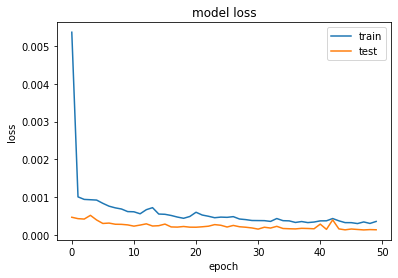

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


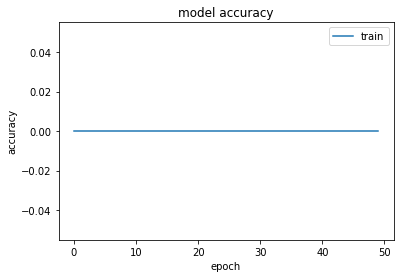

In [22]:
from keras.models import Sequential
from keras.layers import Dense

# list all data in history
print(history.history.keys())

# summarize history for accuracy

plt.size=(10,5)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [23]:
training_data_len
     

1846

C:\Users\DELL\AppData\Local\Temp\ipykernel_936\1369539562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


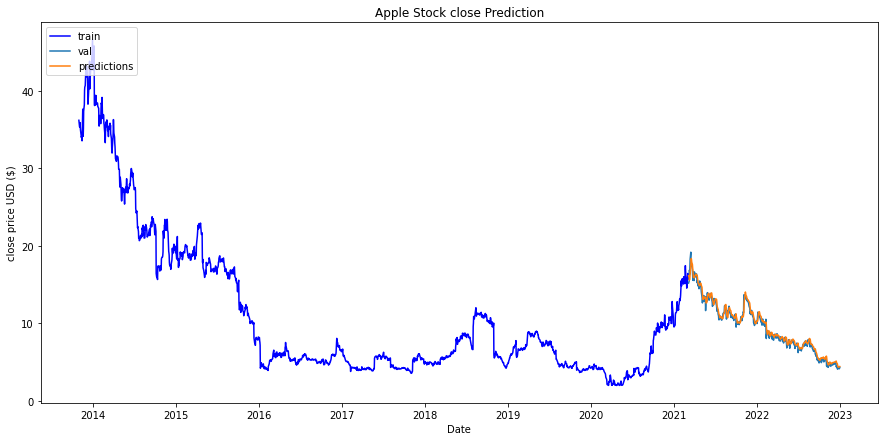

In [24]:
data1 = stock_data.filter(['Close'])
train= data1[:training_data_len]
validation = data1[training_data_len:]
validation['predictions'] = predictions

plt.figure(figsize=(15, 7))
plt.title('Apple Stock close Prediction')
plt.xlabel('Date')
plt.ylabel('close price USD ($)')
plt.plot(train, color='blue')
plt.plot(validation[['Close','predictions']])
plt.legend(['train','val','predictions'],loc='upper left')
plt.show()
     

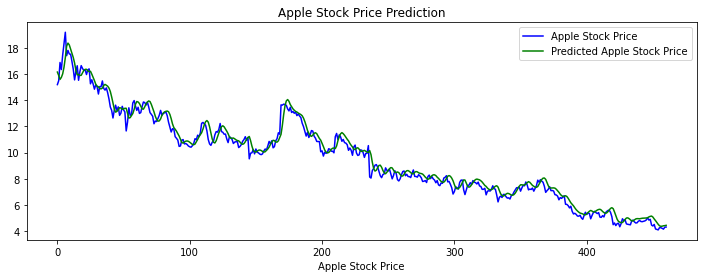

In [25]:
plt.figure(figsize=(12, 4))

real_stock_price = y_test[:]
plt.plot(real_stock_price, color='blue', label='Apple Stock Price')
plt.plot(predictions, color='green', label='Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.xlabel('Apple Stock Price')
plt.legend()
plt.show()